In [13]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta

import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter

from ipypm import ipypm
from pypmca import Model

## Example to produce intervals around future projections

In [26]:
model = Model.open_file('mb_2_9_0830.pypm')
today = (datetime.date.today()-datetime.date(2020,3,1)).days

# projection runs until
end_projection_day = today + 28

# Start stochastic generation on the delta upswing transition date: trans_rate_3_w
begin_stochastic = model.transitions['trans_rate_3_w'].trigger_step

# Hospitalizations and reporting has lags with respect to infections, so start stochastic phase earlier
time_lag = 15
begin_stochastic -= time_lag

# select parameters to smear to represent priors
smear_parameters = {'alpha_3_w':model.parameters['alpha_3_w'].std_estimator,
                    'non_icu_hosp_frac':0.001/1000.}

# point estimates
model.evolve_expectations(end_projection_day)

In [30]:
# number of repetitions
n_rep = 400

# populations to view and the intended presentation
# daily: show differences each day (eg. cumulative cases -> show daily cases)
# total: show directly
pop_names = {'reported':'daily','in_hospital':'total'}

# pop_histories keeps the observed counts
pop_histories = {}
for pop_name in pop_names:
    pop_histories[pop_name] = {}
    for day in range(begin_stochastic,end_projection_day):
        pop_histories[pop_name][day] = []

for i in range(n_rep):
    sim_model = Model.open_file('mb_2_9_0830.pypm')
    for smear_parameter in smear_parameters:
        std = smear_parameters[smear_parameter]
        mean = sim_model.parameters[smear_parameter].get_value()
        value = stats.norm.rvs(loc=mean,scale=std)
        sim_model.parameters[smear_parameter].set_value(value)
    sim_model.generate_data(end_projection_day,data_start=begin_stochastic)
    for pop_name in pop_names:
        pop = sim_model.populations[pop_name]
        for day in range(begin_stochastic,end_projection_day):
            if pop_names[pop_name] == 'daily':
                pop_histories[pop_name][day].append(pop.history[day]-pop.history[day-1])
            else:
                pop_histories[pop_name][day].append(pop.history[day])


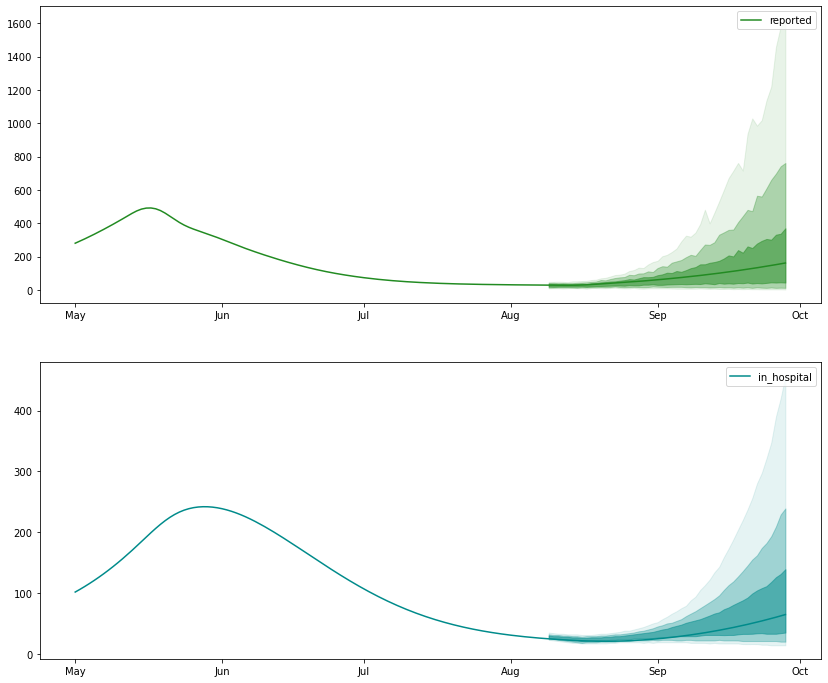

In [32]:
# return daily data from a cumulative array
def daily(cumul):
    diff = []
    for i in range(1,len(cumul)):
        diff.append(cumul[i] - cumul[i-1])
    # first daily value is repeated since val(t0-1) is unknown
    diff.insert(0, diff[0])
    return diff

# dictionary to define quantiles
quant_dicts = [
    {'lower':'0.025', 'upper':'0.975', 'alpha': 0.1},
    {'lower':'0.100', 'upper':'0.900', 'alpha': 0.3},
    {'lower':'0.250', 'upper':'0.750', 'alpha': 0.5}
]

# matplotlib date formatting
formatter = mdates.DateFormatter("%b")
months = mdates.MonthLocator()  # every month
dates = [datetime.date(2020,3,1) + timedelta(days=i) for i in range(end_projection_day)]

# start day for plot
start_day = (datetime.date(2021,5,1)-datetime.date(2020,3,1)).days

# start day for intervals
start_interval_day = begin_stochastic + time_lag

n_plot = len(pop_names)
fig, axes = plt.subplots(n_plot,1,figsize=(14,6*n_plot))

for axis,pop_name in zip(axes,pop_names):
    
    axis.set_yscale('linear')
    axis.xaxis.set_major_formatter(formatter)
    axis.xaxis.set_major_locator(months)

    point_estimates = model.populations[pop_name].history
    if pop_names[pop_name] == 'daily':
        point_estimates = daily(model.populations[pop_name].history)
    
    axis.plot(dates[start_day:end_projection_day],point_estimates[start_day:end_projection_day],
              color = model.populations[pop_name].color, label = pop_name, zorder=3)
    
    for quant_dict in quant_dicts:
        upper = float(quant_dict['upper'])*100.
        lower = float(quant_dict['lower'])*100.
        alpha = quant_dict['alpha']
        upper_quantiles = []
        lower_quantiles = []
        for day in range(start_interval_day,end_projection_day):
            upper_quantiles.append(np.percentile(pop_histories[pop_name][day],upper))
            lower_quantiles.append(np.percentile(pop_histories[pop_name][day],lower))
    
        axis.fill_between(dates[start_interval_day:end_projection_day],lower_quantiles,upper_quantiles,
                          color=model.populations[pop_name].color, zorder=1, alpha=alpha)
        
    axis.legend()
    
plt.show()